# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification with the CIFAR-100 data set


The problem is well understood. In your final project, please utilize some pre-built models. While they are generally large and accurate, they should be used to establish the upper bound of performance. Then, demonstrate the detailed steps you took to develop your own model. Of course, using a random classifier to set a baseline is not meaningful.




# Load Packages and Data with some EDA

In [25]:
import numpy as np 
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier

from keras.datasets import cifar100
from keras.utils import to_categorical

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns
from tensorflow.math import confusion_matrix as tf_confusion_matrix
from tensorflow.keras.callbacks import TensorBoard

import warnings

warnings.filterwarnings('ignore', module='tensorflow')
# warnings.filterwarnings('default')

print('Tensor Flow Version:', tf.__version__)

Tensor Flow Version: 2.15.0


In [26]:
# Load CIFAR-100 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data() 

# normalize pixel values
x_train, x_test = x_train/255, x_test/255

#one hot encode labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [ ]:
# Show sample count by label to visualize the balance of the data
class_labels = y_train.flatten()

plt.figure(figsize=(10,5))
plt.hist(class_labels, bins=np.arange(0,101), alpha=.8, color='green', edgecolor='black')
plt.title(f'Sample Distribution in Classes for CIFAR-100 (n = {len(class_labels)})')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(np.arange(0,101, step=5))
plt.show()


# Display an image from each class in the dataset
distinct_labels = np.unique(y_train)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, label in enumerate(distinct_labels):
    # Get image and label
    idx = np.where(y_train == label)[0]
    random_index = np.random.choice(idx)
    image, label = x_train[random_index], y_train[random_index][0]
    
    # Define grid cell to place image
    row = i // 10
    col = i % 10
    
    # Display image in defined grid cell
    current_image = (image.reshape((32, 32, 3)) * 255).clip(0, 255).astype(int)
    axes[row, col].imshow(current_image, interpolation='nearest')
    axes[row, col].set_title(f"Label: {label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# l1 normalization?

## Callbacks

In [27]:
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)



## CNN Model

In [75]:
#V1
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
#     tf.keras.layers.MaxPool2D((2,2)),

#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPool2D((2,2)),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(100, activation='softmax')
# ])

#V2
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(100, activation='softmax')
])

#V3
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPool2D((2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(100, activation='softmax')
# ])


model.compile(optimizer='adam'
             ,loss='categorical_crossentropy'
             ,metrics=['accuracy']
)

# model.summary()

In [76]:
hist = model.fit(x_train, y_train, 
                 epochs=50,
                 verbose=False, 
                 validation_data=(x_test, y_test), 
                 callbacks=[tensorboard_callback,
                            reduce_lr,
                            early_stopping
                           ]
)

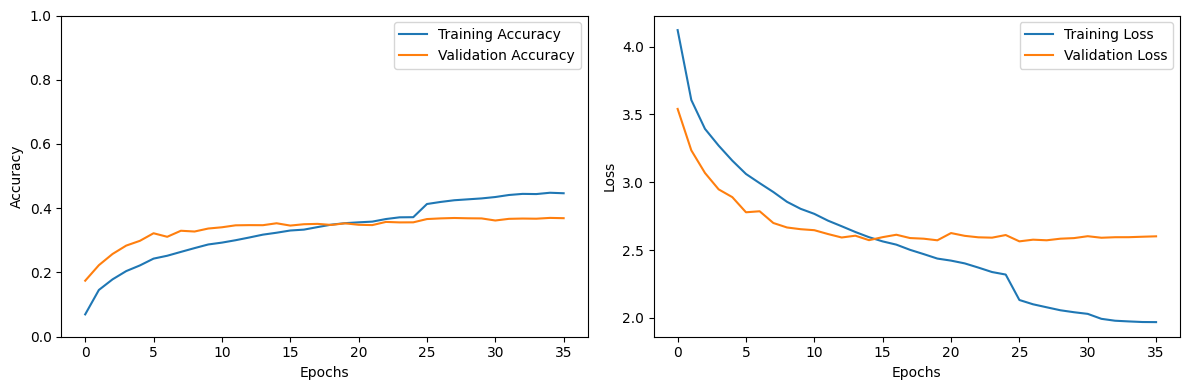

Training Performance:
Final Training Accuracy: 44.66%
Final Training Loss: 1.9683

Validation Performance:
Final Validation Accuracy: 36.9%
Final Validation Loss: 2.6009

Model Performance on Test Data:
Accuracy: 36.63%
Loss: 2.5637


In [78]:
# Plots
plt.figure(figsize=(12, 4))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Training Data
final_train_accuracy = hist.history['accuracy'][-1]
final_train_loss = hist.history['loss'][-1]
print('Training Performance:')
print(f"Final Training Accuracy: {round(final_train_accuracy*100, 2)}%")
print(f"Final Training Loss: {round(final_train_loss, 4)}")

# Validation Data
final_val_accuracy = hist.history['val_accuracy'][-1]
final_val_loss = hist.history['val_loss'][-1]
print('\nValidation Performance:')
print(f"Final Validation Accuracy: {round(final_val_accuracy*100, 2)}%")
print(f"Final Validation Loss: {round(final_val_loss, 4)}")

# Test Data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print('\nModel Performance on Test Data:')
print(f"Accuracy: {round(test_accuracy*100, 2)}%")
print(f"Loss: {round(test_loss, 4)}")

In [ ]:
# model.save('cifar100_model.h5')